In [9]:
pip install google-cloud-aiplatform scikit-learn --upgrade


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [106]:
import json
import os
import logging
from google.cloud import aiplatform
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [108]:
PROJECT_ID = "11630237313"
ENDPOINT_ID = "8456712265620520960"
LOCATION = "us-central1"

VALIDATION_FILE_PATH = "/Users/jokar/Documents/Semester 4/TAP/new_test_aegis_for_vertex_llama3_chat_version.jsonl" 


In [15]:
!gcloud auth application-default login --project={PROJECT_ID}

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=uJSAzUELIZsX69DmbsLFqKeMcetJ6l&access_type=offline&code_challenge=g5HG4nxxVKsMiYB4hQG25KsI8tXY8Ldpl8CwjdEv4fM&code_challenge_method=S256


Credentials saved to file: [/Users/jokar/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "11630237313" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


Updates are available for some Google Cloud CLI compo

In [110]:
def initialize_vertex_client():
    """Initializes the Vertex AI client and endpoint."""
    try:
        endpoint_name = f"projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/{ENDPOINT_ID}"
        endpoint = aiplatform.Endpoint(endpoint_name)
        logger.info(f"Successfully initialized Vertex AI endpoint: {endpoint.display_name}")
        return endpoint
    except Exception as e:
        logger.error(f"Failed to initialize Vertex AI client: {e}")
        return None

In [112]:
def clean_prediction(prediction_text: str) -> str:
    """
    Cleans the raw model output to extract the 'safe' or 'unsafe' label.
    """
    cleaned = prediction_text.strip().lower()
    
    # Check for the label anywhere in the string
    if "unsafe" in cleaned:
        return "unsafe"
    elif "safe" in cleaned:
        return "safe"
    else:
        logger.warning(f"Unexpected prediction format: '{prediction_text}'")
        return "unknown" # Categorize as 'unknown' for metric calculation

In [114]:
def validate_model(endpoint, file_path: str):
    """
    Reads the JSONL file, runs inference, and collects results.
    Stops and raises an error if any line fails to process.
    """
    ground_truths = []
    predictions = []

    if not os.path.exists(file_path):
        logger.error(f"Validation file not found at: {file_path}")
        logger.error("Please update the VALIDATION_FILE_PATH variable in Cell 3.")
        return None, None

    logger.info(f"Starting validation using file: {file_path}")

    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            # The try...except block has been removed.
            # If any error occurs here (JSON, KeyError, etc.),
            # the program will stop as requested.

            item = json.loads(line.strip())

            # 1. Extract Ground Truth
            # {"messages": [..., {"role": "assistant", "content": "unsafe"}]}
            ground_truth = item['messages'][1]['content'].strip().lower()
            ground_truths.append(ground_truth)

            # 2. Prepare the instance for prediction
            # --- CHANGE 1: Build the instance to match your UI sample EXACTLY ---
            instance = {
                "@requestFormat": "chatCompletions",
                "messages": [item['messages'][0]],
                "max_tokens": 50  # Max tokens for the *judgement* (safe/unsafe)
            }

            # 3. Call the Vertex AI Endpoint
            response = endpoint.predict(instances=[instance])
            # 4. Parse the prediction
            # --- CHANGE 2: Revert to the ORIGINAL chat parsing logic ---
            raw_prediction = response.predictions[0][0]['message']['content']
            cleaned_prediction = clean_prediction(raw_prediction)
            predictions.append(cleaned_prediction)

            if (i + 1) % 10 == 0:
                logger.info(f"Processed {i + 1} records...")

    logger.info(f"Finished processing. Total records: {len(ground_truths)}")
    return ground_truths, predictions

In [116]:
def print_metrics(ground_truths, predictions):
    """
    Calculates and prints the classification metrics.
    """
    if not ground_truths or not predictions:
        logger.error("No data to calculate metrics.")
        return

    # Get all unique labels present in either list
    labels = sorted(list(set(ground_truths) | set(predictions)))
    
    print("\n" + "="*30)
    print("--- VALIDATION METRICS ---")
    print("="*30 + "\n")
    
    # 1. Accuracy
    accuracy = accuracy_score(ground_truths, predictions)
    print(f"\n## Overall Accuracy: {accuracy * 100:.2f}%\n")
    
    # 2. Classification Report (Precision, Recall, F1-score)
    print("\n## Classification Report:")
    # Use zero_division=0 to handle cases where a label has 0 support
    report = classification_report(
        ground_truths, 
        predictions, 
        labels=labels, 
        zero_division=0
    )
    print(report)
    
    # 3. Confusion Matrix
    print("\n## Confusion Matrix:")
    print("(Rows: Actual / Columns: Predicted)\n")
    cm = confusion_matrix(ground_truths, predictions, labels=labels)
    
    # Pretty print the confusion matrix
    header = " " * 10 + " | ".join([f"{label:<8}" for label in labels])
    print(header)
    print("-" * len(header))
    for i, label in enumerate(labels):
        row_str = f"{label:<10}| " + " | ".join([f"{cm[i, j]:<8}" for j in range(len(labels))])
        print(row_str)

In [118]:
# --- Main Execution ---

endpoint = initialize_vertex_client()

if endpoint:
    # Run the validation
    ground_truths, predictions = validate_model(endpoint, VALIDATION_FILE_PATH)
    
    # Print the results
    if ground_truths and predictions:
        print_metrics(ground_truths, predictions)
    else:
        logger.error("Validation could not be completed.")
else:
    logger.error("Endpoint not initialized. Please check configuration and authentication.")

E0000 00:00:1761126010.916032 17813282 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
INFO:__main__:Successfully initialized Vertex AI endpoint: llm--as-judge-just-response
INFO:__main__:Starting validation using file: /Users/jokar/Documents/Semester 4/TAP/new_test_aegis_for_vertex_llama3_chat_version.jsonl
E0000 00:00:1761126012.673126 17813282 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761126012.678683 17813282 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
INFO:__main__:Processed 10 records...
INFO:__main__:Processed 20 records...
INFO:__main__:Processed 30 records...
INFO:__main__:Processed 40 records...
INFO:__main__:Processed 50 records...
INFO:__main__:Processed 60 records...
INFO:__main__:Processed 70 records...
INFO:__main__:Processed 80 records...
INFO:__main__:Processed 90 records...
INFO:__main__:Processed 


--- VALIDATION METRICS ---


## Overall Accuracy: 88.78%


## Classification Report:
              precision    recall  f1-score   support

        safe       0.96      0.87      0.91       477
      unsafe       0.78      0.93      0.85       245

    accuracy                           0.89       722
   macro avg       0.87      0.90      0.88       722
weighted avg       0.90      0.89      0.89       722


## Confusion Matrix:
(Rows: Actual / Columns: Predicted)

          safe     | unsafe  
-----------------------------
safe      | 413      | 64      
unsafe    | 17       | 228     



--- VALIDATION METRICS ---


## Overall Accuracy: 88.78%


## Classification Report:
              precision    recall  f1-score   support

        safe       0.96      0.87      0.91       477
      unsafe       0.78      0.93      0.85       245

    accuracy                           0.89       722
   macro avg       0.87      0.90      0.88       722
weighted avg       0.90      0.89      0.89       722


## Confusion Matrix (Text):
(Rows: Actual / Columns: Predicted)

          safe     | unsafe  
-----------------------------
safe      | 413      | 64      
unsafe    | 17       | 228     

Successfully saved confusion matrix plot to confusion_matrix.png


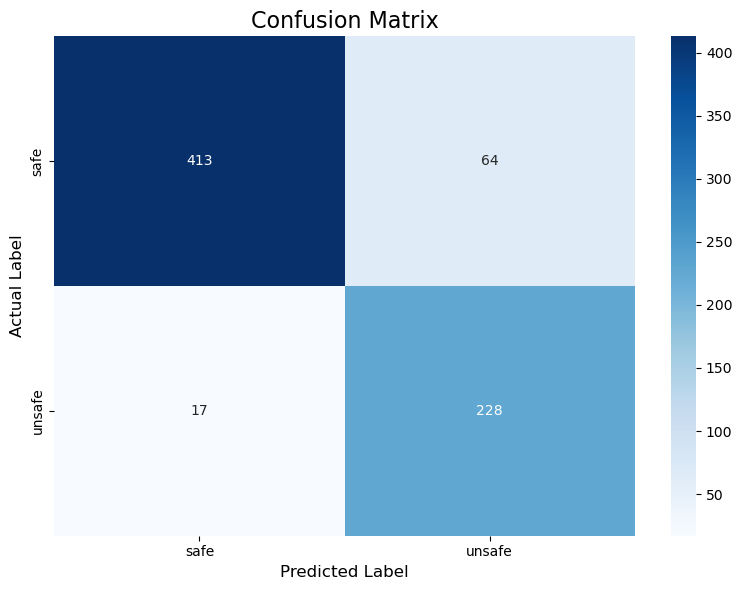

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def print_metrics(ground_truths, predictions):
    """
    Calculates and prints the classification metrics, and saves a confusion matrix plot.
    """
    if not ground_truths or not predictions:
        logger.error("No data to calculate metrics.")
        return

    # Get all unique labels present in either list
    labels = sorted(list(set(ground_truths) | set(predictions)))
    
    print("\n" + "="*30)
    print("--- VALIDATION METRICS ---")
    print("="*30 + "\n")
    
    # 1. Accuracy
    accuracy = accuracy_score(ground_truths, predictions)
    print(f"\n## Overall Accuracy: {accuracy * 100:.2f}%\n")
    
    # 2. Classification Report (Precision, Recall, F1-score)
    print("\n## Classification Report:")
    report = classification_report(
        ground_truths, 
        predictions, 
        labels=labels, 
        zero_division=0
    )
    print(report)
    
    # 3. Confusion Matrix (Text)
    print("\n## Confusion Matrix (Text):")
    print("(Rows: Actual / Columns: Predicted)\n")
    cm = confusion_matrix(ground_truths, predictions, labels=labels)
    
    # Pretty print the text confusion matrix
    header = " " * 10 + " | ".join([f"{label:<8}" for label in labels])
    print(header)
    print("-" * len(header))
    for i, label in enumerate(labels):
        row_str = f"{label:<10}| " + " | ".join([f"{cm[i, j]:<8}" for j in range(len(labels))])
        print(row_str)
        
    # 4. Generate Confusion Matrix Plot
    try:
        # Create the figure
        plt.figure(figsize=(8, 6))
        
        # Use seaborn to create a heatmap
        sns.heatmap(cm, 
                    annot=True,     # Show the numbers in each cell
                    fmt='d',        # Format as integers
                    cmap='Blues',   # Color scheme
                    xticklabels=labels, 
                    yticklabels=labels)
        
        # Add labels and title
        plt.title('Confusion Matrix', fontsize=16)
        plt.ylabel('Actual Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        
        # Save the plot
        plot_filename = "confusion_matrix.png"
        plt.savefig(plot_filename)
        print(f"\nSuccessfully saved confusion matrix plot to {plot_filename}")
        
    except Exception as e:
        logger.error(f"Failed to generate plot: {e}")


if ground_truths and predictions:
    print_metrics(ground_truths, predictions)